In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

import re

from sklearn import model_selection, preprocessing, naive_bayes, metrics, svm
from sklearn import decomposition, ensemble
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from keras.preprocessing import text, sequence

from gensim.models import Word2Vec

/home/olek/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def normalize_text(text, punctuation=True, prune=True, stem=True):
    
    # Step 1: Separate hyphenated words so they are not filtered when punctuation is removed
    output = text.replace('-', ' ')

    # Step 2: Tokenize
    output = word_tokenize(output)

    # Step 3: Convert to lowercase
    output = [word.lower() for word in output]

    # Step 4: Remove punctuation & numbers
    if punctuation:
        output = [word for word in output if word.isalpha()]

    # Step 5: Remove stop words, removed uninformative tokens, helps reduce volume of tokens
    if prune:
        stop_words = set(stopwords.words('english'))
        output = [word for word in output if not word in stop_words]
    
    # Step 6: Stem words, helps reduce volume of tokens by removing distinctions between words with same stem
    if stem:
        porter = PorterStemmer()
        output = [porter.stem(word) for word in output]

    return(output)

In [3]:
# load raw data
raw_data = pd.read_csv('Consumer_Complaints.csv')

# create data frame with relevant columns and remove missing values
data = pd.DataFrame()
data['product'] = raw_data['Product']
data['complaint'] = raw_data['Consumer complaint narrative'].astype('U')
data = data[pd.notnull(raw_data['Consumer complaint narrative'])]

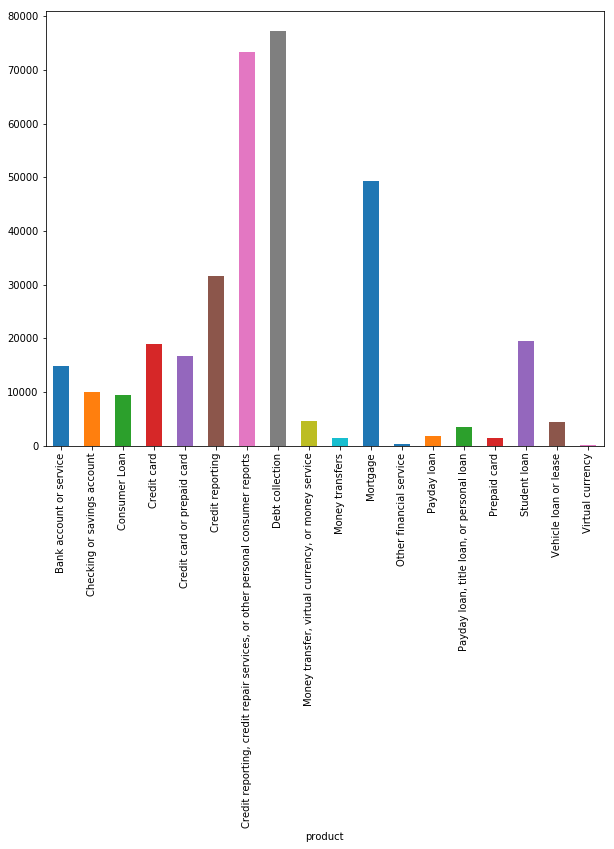

In [4]:
# check for unbalanced classes
counts = data.groupby('product').complaint.count()
fig = plt.figure(figsize=(10,8))
counts.plot.bar(ylim=0)

# The classes are highly unbalanced, There are 18 classes, remove the two smallest ones \w > 300 points
#data = data[~data['product'].isin(['Virtual currency', 'Other financial service'])]

In [5]:
# The classes are highly unbalanced, There are 18 classes, remove the two smallest ones \w > 300 points
data = data[~data['product'].isin(['Virtual currency', 'Other financial service'])]

# encode class names as integers
data['class'] = data['product'].factorize()[0]

# create a mapping between string classes and their integer representations
label_encodings = data[['product', 'class']].drop_duplicates().sort_values('class')
label_encodings_dict = dict(label_encodings.values)

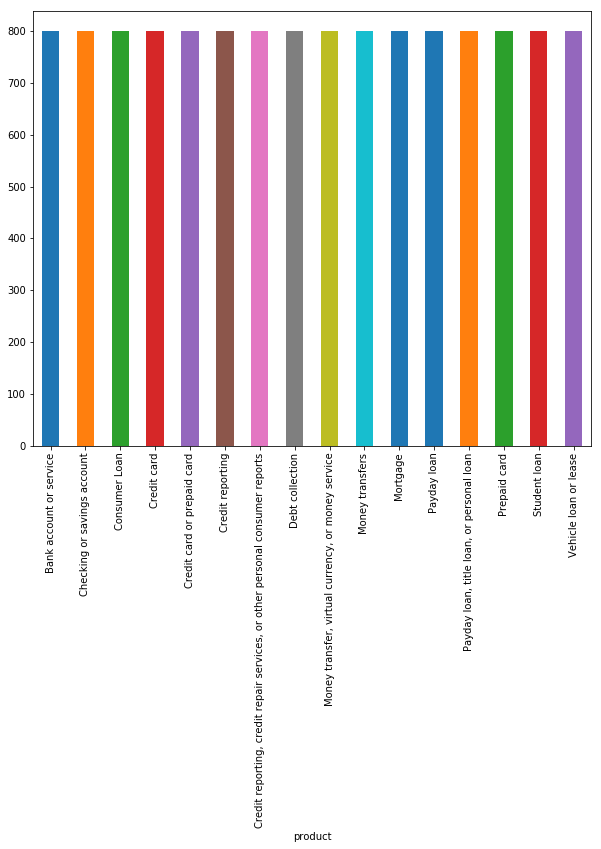

In [6]:
# Out of 16 remaning classes 'Checking or savings account' is the 8th smallest with n = 9980. 
# Oversample all smaller classes to 9980, subsample all larger classes to 9980.
counts = data.groupby('class').complaint.count()
summary = pd.DataFrame()
summary['class'] = counts.index
summary['counts'] = counts.values

# sample indices and construct sampled data set with 16 classes, each with 9980 points sampled with replacement
np.random.seed(1986)

index_dict = dict()
#indices = np.zeros((9980,16)).astype(int)
indices = np.zeros((800,16)).astype(int)
sampled_data = pd.DataFrame()

for i in range(summary.shape[0]):  
    index_dict[i] = data[data['class'] == i].index
    #indices[:,i]  = np.random.choice(index_dict[i], size=9980)
    indices[:,i]  = np.random.choice(index_dict[i], size=800)
    sampled_data = sampled_data.append(data.loc[indices[:,i]])

counts = sampled_data.groupby('product').complaint.count()
fig = plt.figure(figsize=(10,8))
counts.plot.bar(ylim=0)

In [7]:
# preprocess complaint text (takes 5 mins)
sampled_data['complaint'] = [re.sub('X{2,}', '', d) for d in sampled_data['complaint']] # remove XXX spans
sampled_data['complaint'] = [normalize_text(d) for d in sampled_data['complaint']]

In [8]:
# stitch list of strings back together into a space-separated single string per description
sampled_data['complaint'] = [' '.join(word_list) for word_list in sampled_data['complaint']]

In [ ]:
sampled_data['complaint'][1073893]

In [9]:
# split data into training and testing sets (75:25 train-test split by default)
train_x, test_x, train_y, test_y = model_selection.train_test_split(sampled_data['complaint'], sampled_data['class'])

train_x.shape #9600
test_x.shape #3200

(3200,)

In [10]:
# Feature engineering part 1: bag of words model

#unigram counts
# create a count vectorizer object, switch off all normalizing features done earlier with NLTK
unigram_vectorizer = CountVectorizer(analyzer='word', lowercase=False)
unigram_vectorizer.fit(sampled_data['complaint'])

# transform training and test data using vectorizer object
train_x_unigram_count =  unigram_vectorizer.transform(train_x)
test_x_unigram_count =  unigram_vectorizer.transform(test_x)

#bigram counts
bigram_vectorizer = CountVectorizer(analyzer='word', lowercase=False, ngram_range=(2,2))
bigram_vectorizer.fit(sampled_data['complaint'])
train_x_bigram_count =  bigram_vectorizer.transform(train_x)
test_x_bigram_count =  bigram_vectorizer.transform(test_x)

In [ ]:
train_x_unigram_count.shape

In [ ]:
unigram_vectorizer.vocabulary_

In [ ]:
bigram_vectorizer.vocabulary_

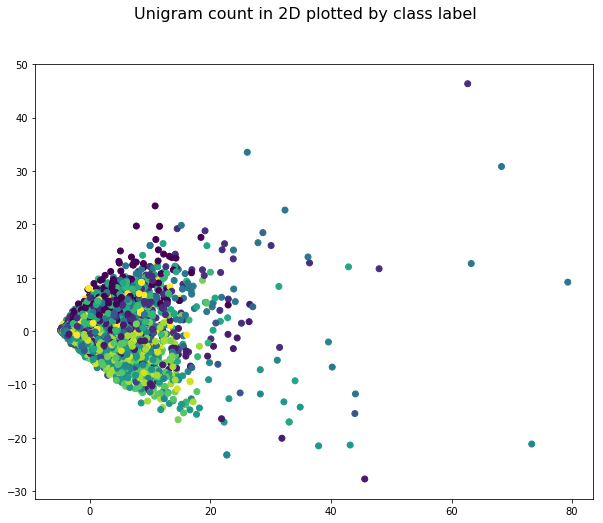

In [11]:
pca = decomposition.PCA(n_components=2).fit(train_x_unigram_count.todense())
unigram_count_2D = pca.transform(train_x_unigram_count.todense())

y = train_y.values

encoder = preprocessing.LabelEncoder()
y = encoder.fit_transform(y)

unigram_count_2D = np.c_[unigram_count_2D, y]

fig = plt.figure(figsize=(10,8))
fig.suptitle('Unigram count in 2D plotted by class label', fontsize=16)
plt.scatter(unigram_count_2D[:,0], unigram_count_2D[:,1], c=unigram_count_2D[:,2])

In [12]:
# Feature engineering part 2: TF-IDF vectors

# unigram TF-IDFs
unigram_tfidf_vectorizer = TfidfVectorizer(analyzer='word', lowercase=False)
unigram_tfidf_vectorizer.fit(sampled_data['complaint'])
train_x_unigram_tfidf =  unigram_tfidf_vectorizer.transform(train_x)
test_x_unigram_tfidf =  unigram_tfidf_vectorizer.transform(test_x)

# bigram TF-IDFs
bigram_tfidf_vectorizer = TfidfVectorizer(analyzer='word', lowercase=False, ngram_range=(2,2))
bigram_tfidf_vectorizer.fit(sampled_data['complaint'])
train_x_bigram_tfidf =  bigram_tfidf_vectorizer.transform(train_x)
test_x_bigram_tfidf =  bigram_tfidf_vectorizer.transform(test_x)

In [ ]:
train_x_unigram_tfidf.shape

In [ ]:
unigram_tfidf_2D = pca.transform(train_x_unigram_tfidf.todense())

y = train_y.values

encoder = preprocessing.LabelEncoder()
y = encoder.fit_transform(y)

unigram_tfidf_2D = np.c_[unigram_tfidf_2D, y]


fig = plt.figure(figsize=(10,6))
fig.suptitle('Unigram TF-IDF in 2D plotted by class label', fontsize=16)
plt.scatter(unigram_tfidf_2D[:,0], unigram_tfidf_2D[:,1], c=unigram_tfidf_2D[:,2])

In [13]:
# Feature engineering part 3: cosine similarity vectors

# unigram cosine similarity
train_x_unigram_cos_sim = cosine_similarity(train_x_unigram_tfidf)
test_x_unigram_cos_sim = cosine_similarity(test_x_unigram_tfidf)
    
# bigram cosine similarity
train_x_bigram_cos_sim = cosine_similarity(train_x_bigram_tfidf)
test_x_bigram_cos_sim = cosine_similarity(test_x_bigram_tfidf)

In [14]:
train_x_unigram_cos_sim.shape

(9600, 9600)

In [31]:
a = np.random.random(4)
b = np.random.random(4)
c = np.random.random(4)
d = np.random.random(4)

mat = np.concatenate(([a], [b],[c], [d]))
mat[0,0] = 1
mat[1,1] = 1
mat[2,2] = 1
mat[3,3] = 1

mat

array([[1.        , 0.86437324, 0.08819594, 0.94283992],
       [0.10071309, 1.        , 0.49186956, 0.33525655],
       [0.3799149 , 0.57163169, 1.        , 0.28013816],
       [0.54254486, 0.95611016, 0.85825964, 1.        ]])

In [32]:
labels = [1,1,0,2]

In [40]:
k = 2

scores_matrix = mat
#train_y = labels

total = len(labels)

for i in range(total):
    scores = np.sort(scores_matrix[i,:])[::-1]
    
for j in k:
    if scores[j] 

In [41]:
from scipy.cluster import  hierarchy

#Vectorizing
X = CountVectorizer().fit_transform(docs)
X = TfidfTransformer().fit_transform(X)
#Clustering
X = X.todense()
threshold = 0.1
Z = hierarchy.linkage(X,"average", metric="cosine")
C = hierarchy.fcluster(Z, threshold, criterion="distance")

array([1.        , 0.95611016, 0.85825964, 0.54254486])

In [ ]:
# model function
def classifier(model, train_features, train_labels, test_features, test_labels):
    
    # define the model and (when appropriate) the relevant parameters
    clf = model
    
    #Train the model using the training sets
    clf.fit(train_features, train_labels)
    
    #Predict the response for test dataset
    preds = clf.predict(test_features)
    accuracy = metrics.accuracy_score(test_labels, preds)
    
    #f1_score = metrics.f1_score(test_labels, preds, average="macro")
    #precision = metrics.precision_score(test_labels, preds, average="macro")
    #recall = metrics.recall_score(test_labels, preds, average="macro")

    #return(accuracy, f1_score, precision, recall)
    
    return(accuracy)

In [ ]:
# initialize accuracy vector for each feature matrix trained on each of 4 considered model types
uni_count_acc = np.zeros(4)
bi_count_acc = np.zeros(4)
uni_tfidf_acc = np.zeros(4)
bi_tfidf_acc = np.zeros(4)
uni_cos_sim = np.zeros(4)
bi_cos_sim = np.zeros(4)

In [ ]:
# Model 1: Multinomial Naive Bayes - simple majority class classifier, serves as a benchmark 

uni_count_acc[0] = round(classifier(naive_bayes.MultinomialNB(), train_x_unigram_count, train_y, test_x_unigram_count, test_y), 4)
bi_count_acc[0] = round(classifier(naive_bayes.MultinomialNB(), train_x_bigram_count, train_y, test_x_bigram_count, test_y), 4)
uni_tfidf_acc[0] = round(classifier(naive_bayes.MultinomialNB(), train_x_unigram_tfidf, train_y, test_x_unigram_tfidf, test_y), 4)
bi_tfidf_acc[0] = round(classifier(naive_bayes.MultinomialNB(), train_x_bigram_tfidf, train_y, test_x_bigram_tfidf, test_y), 4)
uni_cos_sim_acc[0] = round(classifier(naive_bayes.MultinomialNB(), train_x_unigram_cos_sim, train_y, test_x_unigram_cos_sim, test_y), 4)
bi_cos_sim_acc[0] = round(classifier(naive_bayes.MultinomialNB(), train_x_bigram_cos_sim, train_y, test_x_bigram_cos_sim, test_y), 4)

In [ ]:
# Model 2: Support Vector Classifier - known to perform well for multiclass classification problems, but prone to overfitting

uni_count_acc[1] = round(classifier(svm.SVC(kernel='linear'), train_x_unigram_count, train_y, test_x_unigram_count, test_y), 4)
bi_count_acc[1] = round(classifier(svm.SVC(kernel='linear'), train_x_bigram_count, train_y, test_x_bigram_count, test_y), 4)
uni_tfidf_acc[1] = round(classifier(svm.SVC(kernel='linear'), train_x_unigram_tfidf, train_y, test_x_unigram_tfidf, test_y), 4)
bi_tfidf_acc[1] = round(classifier(svm.SVC(kernel='linear'), train_x_bigram_tfidf, train_y, test_x_bigram_tfidf, test_y), 4)
uni_cos_sim_acc[1] = round(classifier(svm.SVC(kernel='linear'), train_x_unigram_cos_sim, train_y, test_x_unigram_cos_sim, test_y), 4)
bi_cos_sim_acc[1] = round(classifier(svm.SVC(kernel='linear'), train_x_bigram_cos_sim, train_y, test_x_bigram_cos_sim, test_y), 4)

In [ ]:
# Model 3: Random Forest - a non-parametric alternative that samples small batches of predictors at a time, eliminating collinearity and overfitting

uni_count_acc[2] = round(classifier(ensemble.RandomForestClassifier(n_estimators=100), train_x_unigram_count, train_y, test_x_unigram_count, test_y), 4)
bi_count_acc[2] = round(classifier(ensemble.RandomForestClassifier(n_estimators=100), train_x_bigram_count, train_y, test_x_bigram_count, test_y), 4)
uni_tfidf_acc[2] = round(classifier(ensemble.RandomForestClassifier(n_estimators=100), train_x_unigram_tfidf, train_y, test_x_unigram_tfidf, test_y), 4)
bi_tfidf_acc[2] = round(classifier(ensemble.RandomForestClassifier(n_estimators=100), train_x_bigram_tfidf, train_y, test_x_bigram_tfidf, test_y), 4)
uni_cos_sim_acc[2] = round(classifier(ensemble.RandomForestClassifier(n_estimators=100), train_x_unigram_cos_sim, train_y, test_x_unigram_cos_sim, test_y), 4)
bi_cos_sim_acc[2] = round(classifier(ensemble.RandomForestClassifier(n_estimators=100), train_x_bigram_cos_sim, train_y, test_x_bigram_cos_sim, test_y), 4)

In [ ]:
# Model 4: Regualrized SVC with Lasso (L1) penalty - performs implicit variable selection reducing collinearity and overfitting

uni_count_acc[3] = round(classifier(svm.LinearSVC(penalty='l1', dual=False), train_x_unigram_count, train_y, test_x_unigram_count, test_y), 4)
bi_count_acc[3] = round(classifier(svm.LinearSVC(penalty='l1', dual=False), train_x_bigram_count, train_y, test_x_bigram_count, test_y), 4)
uni_tfidf_acc[3] = round(classifier(svm.LinearSVC(penalty='l1', dual=False), train_x_unigram_tfidf, train_y, test_x_unigram_tfidf, test_y), 4)
bi_tfidf_acc[3] = round(classifier(svm.LinearSVC(penalty='l1', dual=False), train_x_bigram_tfidf, train_y, test_x_bigram_tfidf, test_y), 4)
uni_cos_sim_acc[3] = round(classifier(svm.LinearSVC(penalty='l1', dual=False), train_x_unigram_cos_sim, train_y, test_x_unigram_cos_sim, test_y), 4)
bi_cos_sim_acc[3] = round(classifier(svm.LinearSVC(penalty='l1', dual=False), train_x_bigram_cos_sim, train_y, test_x_bigram_cos_sim, test_y), 4)

In [ ]:
results = pd.DataFrame()
results['unigram count'] = uni_count_acc
results['bigram count'] = bi_count_acc
results['unigram TF-IDF'] = uni_tfidf_acc
results['bigram TF-IDF'] = bi_tfidf_acc
results['unigram cos sim'] = uni_cos_sim_acc
results['unigram cos sim'] = bi_cos_sim_acc
results.rename(index={0:'Naive Bayes', 1:'Linear SVC', 2: 'Random Forest', 3:'Linear SVC + L1'}, inplace=True)
print(results)

In [ ]:
round(classifier(naive_bayes.MultinomialNB(), train_x_unigram_cos_sim, train_y, test_x_unigram_cos_sim, test_y), 4)

In [ ]:
#clf = naive_bayes.MultinomialNB()

#clf.fit(train_x_unigram_cos_sim, train_y)

#clf.predict(test_x_unigram_cos_sim)

train_x_unigram_cos_sim.shape[1]